# Swingup of a pendulum on a cart using nonlinear MPC

This notebook demonstrates how to use a nonlinear MPC controller to swing up an inverted pendulum on a cart. The controller is implemented using the `NonlinearMPC` package built with Casadi.

## System Dynamics

We start by defining the system dynamics for the inverted pendulum on a cart.


In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from openmpc.NonlinearMPC import NonlinearSystem, MPC

# Define the ODE right-hand side function for the inverted pendulum on a cart
x = ca.MX.sym("x")
x_dot = ca.MX.sym("x_dot")
theta = ca.MX.sym("theta")
theta_dot = ca.MX.sym("theta_dot")
u = ca.MX.sym("u")  # Control input (acceleration of the cart)

# Constants
M = 0.5  # Mass of the cart
m = 0.2  # Mass of the pendulum
b = 0.1  # Damping coefficient
l = 0.3  # Length to pendulum center of mass
I = 0.006  # Moment of inertia of the pendulum
g = 9.81  # Acceleration due to gravity

# Intermediate calculations
cos_theta = ca.cos(theta)
sin_theta = ca.sin(theta)
d = (M + m) * (I + m * l**2) - (m * l * cos_theta)**2

# Dynamics equations
x_ddot = (I + m * l**2) * (u - b * x_dot + m * l * theta_dot**2 * sin_theta) + \
         (m * l * cos_theta) * (m * l * g * sin_theta)
x_ddot = x_ddot / d

theta_ddot = ((M + m) * (m * l * g * sin_theta) + (m * l * cos_theta) * (u - b * x_dot - m * l * theta_dot**2 * sin_theta)) / d

rhs = ca.vertcat(
    x_dot,           # dx/dt
    x_ddot,          # d(x_dot)/dt
    theta_dot,       # d(theta)/dt
    theta_ddot       # d(theta_dot)/dt
)

# Define the state and input vectors
states = ca.vertcat(x, x_dot, theta, theta_dot)
inputs = u

# Create the NonlinearSystem object
cartPendulumSystem = NonlinearSystem(updfcn=rhs, states=states, inputs=inputs, outfcn=states)

# Define sampling time and discrete-time prediction model
h = 0.1
predictionModel=cartPendulumSystem.c2d(h)

## Simulation Model

Next, we define the simulation model with potentially perturbed parameters to simulate the real-world scenario more accurately.


In [2]:
# Constants for the simulation model (perturbed values)
M_sim = 0.5  # Mass of the cart
m_sim = 0.2  # Mass of the pendulum
b_sim = 0.1  # Damping coefficient
l_sim = 0.3  # Length to pendulum center of mass
I_sim = 0.006  # Moment of inertia of the pendulum
g_sim = 9.81  # Acceleration due to gravity (same as prediction model)

# Intermediate calculations for the simulation model
cos_theta_sim = ca.cos(theta)
sin_theta_sim = ca.sin(theta)
d_sim = (M_sim + m_sim) * (I_sim + m_sim * l_sim**2) - (m_sim * l_sim * cos_theta_sim)**2

# Dynamics equations for the simulation model
x_ddot_sim = (I_sim + m_sim * l_sim**2) * (u - b_sim * x_dot + m_sim * l_sim * theta_dot**2 * sin_theta_sim) + \
             (m_sim * l_sim * cos_theta_sim) * (m_sim * l_sim * g_sim * sin_theta_sim)
x_ddot_sim = x_ddot_sim / d_sim

theta_ddot_sim = ((M_sim + m_sim) * (m_sim * l_sim * g_sim * sin_theta_sim) + (m_sim * l_sim * cos_theta_sim) * (u - b_sim * x_dot - m_sim * l_sim * theta_dot**2 * sin_theta_sim)) / d_sim

rhs_sim = ca.vertcat(
    x_dot,           # dx/dt
    x_ddot_sim,      # d(x_dot)/dt
    theta_dot,       # d(theta)/dt
    theta_ddot_sim   # d(theta_dot)/dt
)

# Define the state and input vectors
states = ca.vertcat(x, x_dot, theta, theta_dot)
inputs = u

# Create the NonlinearSystem object for the simulation model
simulationModel = NonlinearSystem(updfcn=rhs, states=states, inputs=inputs, outfcn=states).c2d(h)

## MPC Problem Setup

We now set up the MPC problem by defining the parameters, constraints, and the LQR controller for the terminal cost.


In [4]:
# Define MPC parameters

Q=np.diag([1, 1, 1, 1])
R=np.diag([1])
L, P, _ = predictionModel.compute_lqr_controller(Q, R)

mpcProblemData = {
    'N': 15,
    'dt': 0.1,  # sampling time
    'Q': Q,
    'R': R,
    'Q_N': P,
    'predictionModel': predictionModel,
    'umin': np.array([-10]),  # Control limits
    'umax': np.array([10]),  # Control limits
    'baseController': L,
    'slackPenaltyWeight': 1e6,  # Slack penalty weight
    'dualModeHorizon': 15,  # Dual mode horizon
    'dualModeController': L
}

# Initialize the MPC controller
mpc_controller = MPC(mpcProblemData)


## Simulation

We simulate the system using the defined MPC controller and the simulation model.


In [6]:
# Simulation parameters
Tsim = 5.0  # Total simulation time
dt = mpcProblemData['dt']  # Sampling time from MPC problem data
N_steps = int(Tsim / dt)  # Number of simulation steps

# Initial state
x0 = np.array([-1, 0, np.pi, 0])  # Initial state [position, velocity, angle, angular velocity]

# Initialize state and control trajectories for simulation
x_sim = [x0]
u_sim = []

# Create the Runge-Kutta integrator for the simulation model
#sim_integrator = RK(simulationModel, dt, order=4)

# Extract Q and R from mpcProblemData
Q = mpcProblemData['Q']
R = mpcProblemData['R']

# Initialize the total cost
total_cost = 0

# Simulation loop
for k in range(N_steps):
    # Get the current state
    x_current = x_sim[-1]
    
    # Compute the control action using the MPC controller
    try:
        u_current = mpc_controller.get_control_action(x_current)
    except Exception as e:
        print(f"Error at simulation step {k}: {e}")
        break
    
    # Integrate the state using the simulation model
    x_next = simulationModel.updfcn(x_current, u_current).full().flatten()
    
    # Compute the stage cost
    stage_cost = np.dot(x_current.T, np.dot(Q, x_current)) + np.dot(u_current.T, np.dot(R, u_current))
    total_cost += stage_cost
    
    # Store the control action and the next state
    u_sim.append(u_current)
    x_sim.append(x_next)

    # Print status every second of simulation time
    if (k + 1) % int(1 / dt) == 0:
        sim_time = (k + 1) * dt
        print(f"Simulation time: {sim_time:.2f} seconds. Current system state: {x_next}")

# Convert simulation results to numpy arrays for plotting
x_sim = np.array(x_sim).T
u_sim = np.array(u_sim).T

# Print the total cost
print(f"Total cost over the simulation horizon: {total_cost}")



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Simulation time: 1.00 seconds. Current system state: [-1.4603951  -0.772248    3.65452041 -3.43347361]
Simulation time: 2.00 seconds. Current system state: [-0.21027916  0.50737467  0.19314676 -0.57022638]
Simulation time: 3.00 seconds. Current system state: [-0.00082496  0.06016171  0.01731212 -0.03478251]
Simulation time: 4.00 seconds. Current system state: [ 0.01825283 -0.00315802  0.00233792 -0.0055723 ]
Simulation time: 5.00 seconds. Current system state: [ 0.01090159 -0.00815133 -0.00017467 -0.00077088]
Total cost over the simulation horizon: [[591.04019852]]


## Results

Finally, we plot the state and control trajectories over the simulation time.


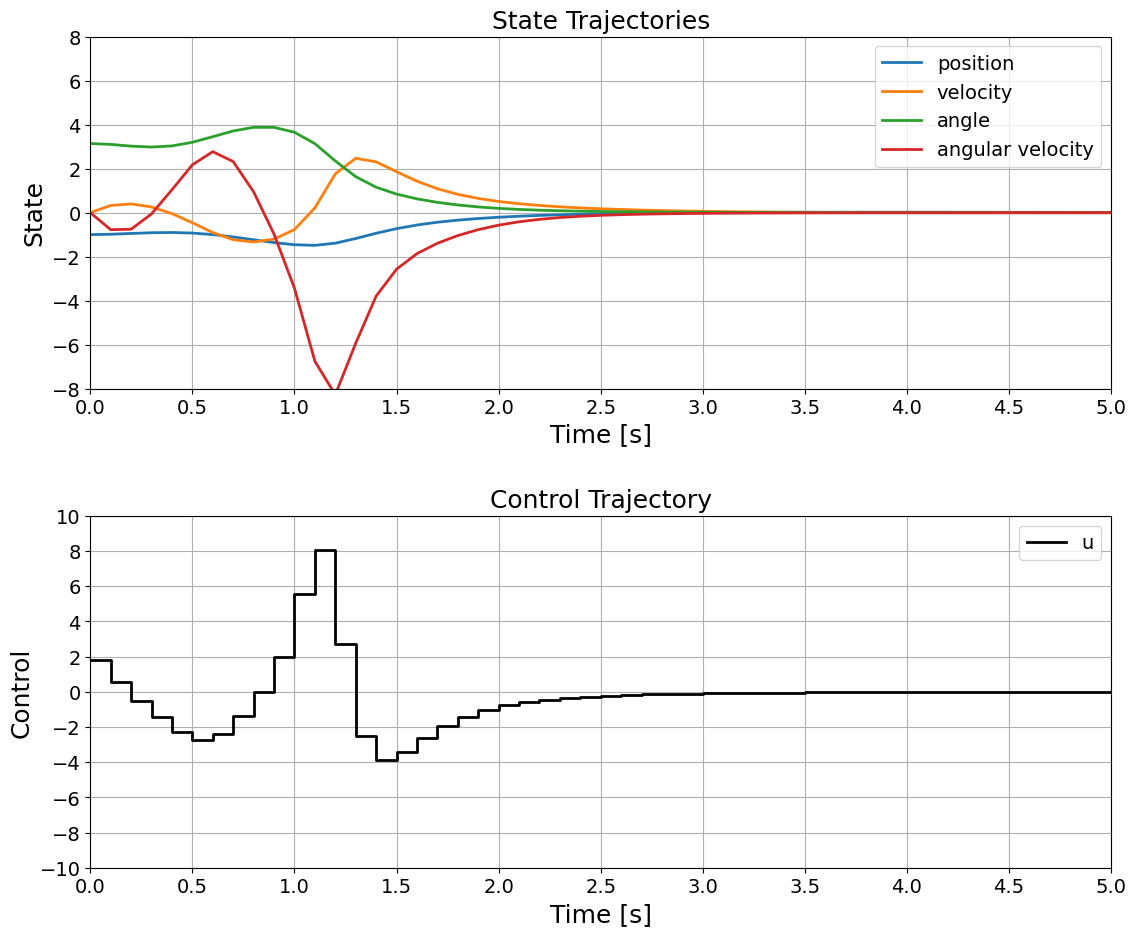

In [7]:
import matplotlib.ticker as ticker

# Time grid for plotting
t_sim = np.linspace(0, Tsim, N_steps + 1)

# Flatten and extend the control signal for plotting
u_sim_flat = u_sim.flatten()
u_sim_extended = np.append(u_sim_flat, u_sim_flat[-1])

# Adjust time grid for control signal to match extended control signal length
t_sim_extended = np.append(t_sim[:-1], Tsim)

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the state trajectories on the first subplot
ax1.plot(t_sim, x_sim[0, :], label='position', linewidth=2)
ax1.plot(t_sim, x_sim[1, :], label='velocity', linewidth=2)
ax1.plot(t_sim, x_sim[2, :], label='angle', linewidth=2)
ax1.plot(t_sim, x_sim[3, :], label='angular velocity', linewidth=2)
ax1.set_xlabel('Time [s]', fontsize=18)
ax1.set_ylabel('State', fontsize=18)
ax1.set_xlim([0, Tsim])
ax1.set_ylim([-8, 8])
ax1.legend(fontsize=14)
ax1.set_title('State Trajectories', fontsize=18)
ax1.grid(True)

# Set grid steps
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(2))

# Plot the control trajectory on the second subplot
ax2.step(t_sim_extended, u_sim_extended, 'k', label='u', where='post', linewidth=2)
ax2.set_xlabel('Time [s]', fontsize=18)
ax2.set_ylabel('Control', fontsize=18)
ax2.set_xlim([0, Tsim])
ax2.set_ylim([-10, 10])
ax2.legend(fontsize=14)
ax2.set_title('Control Trajectory', fontsize=18)
ax2.grid(True)

# Set grid steps
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(2))

# Set tick font size
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

# Adjust layout to make space for larger labels
plt.tight_layout(pad=3.0)

# Save the plot as a PDF file
plt.savefig('mpc_simulation_cartpend.pdf', format='pdf')

# Show the plots
plt.show()
